# Projet M1 

#### Dépendances

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as sw
from scipy import signal
from scipy.signal import butter, lfilter

# Fichier audio

Cette section contient l'étude du fichier audio chargé. Vous pourrez y trouver son spectre d'amplitude ainsi que son spectrogramme.

Vous pouvez configurer la source du fichier audio dans la cellule ci-dessous.

In [2]:
# Source
file = "src/test2.wav"

#### Spectre d'amplitude

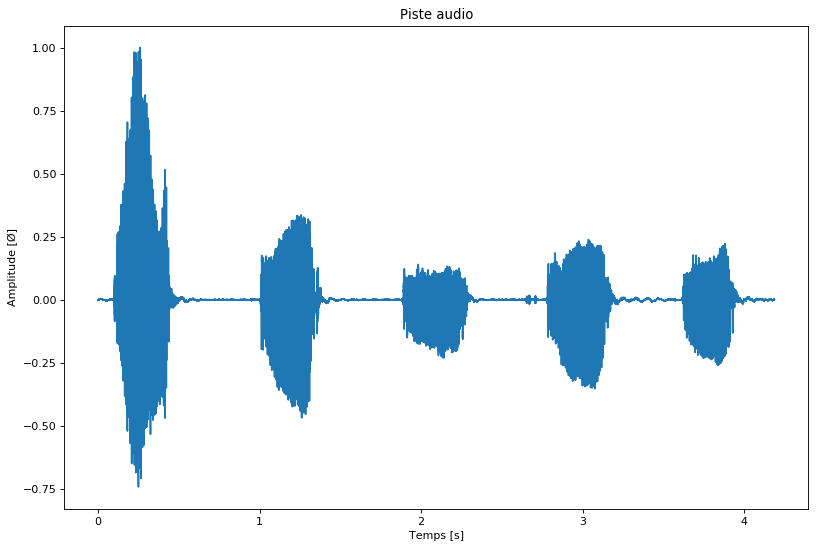

In [3]:
# Lecture du fichier audio
fs, y = sw.read(file)
# y = np.array(y, dtype=float)
yn = y/max(y)

# Nombre d'échantillons et échelle temporelle
N = len(y)
t = np.linspace(0, N/fs, N)

# Affichage du spectre d'amplitude
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Piste audio')
plt.xlabel('Temps [s]')
plt.ylabel('Amplitude [Ø]')
plt.plot(t, yn)
plt.show()

#### Spectrogramme

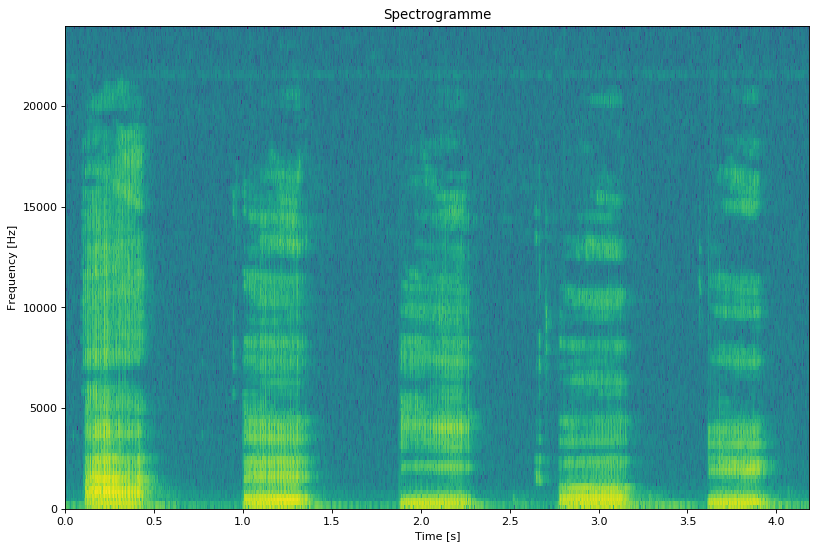

In [4]:
# Affichage du spectrogramme
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Spectrogramme')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.specgram(y, Fs=fs)
plt.show()


# Banque de filtres

In [5]:
# Ordre des filtres
n = 3
# Facteur de qualité
q = 3
# Nombre de filtres
nb_filters = 16
# Fréquence minimal
fmin = 300
# Fréquence maximal
fmax = 3000

#### Passe-bande (butterworth)
La fonction ci-dessous permet de générer un filtre passe-bande analogique.
* fc : Fréquence centrale
* q : Facteur de qualité
* n : Ordre du filtre

In [6]:
def bandpass(fc, q, n, fs):
    # Calcul de la bande passante grâce au facteur de qualité
    df = fc / q
    # Calcul de la fréquence de Nyquist
    nyq = fs / 2
    # Détermination des fréquences de coupures basses et hautes
    fl = (fc - df/2) / nyq
    fh = (fc + df/2) / nyq
    print(fc, fl, fh, nyq)
    # Création du filtre de butterworth    
    return butter(N=n, Wn=[fl, fh], btype='band')

#### Génération de la banque de filtres

In [7]:
# Banque des filtres
filters = []
# Calcul du pas
step = round((fmax-fmin)/nb_filters)
# Génération des filtres
for fc in range(fmin, fmax, step):
    filters.append(bandpass(fc, q, n, fs))

300 0.010416666666666666 0.014583333333333334 24000.0
469 0.01628472222222222 0.02279861111111111 24000.0
638 0.022152777777777775 0.03101388888888889 24000.0
807 0.02802083333333333 0.03922916666666667 24000.0
976 0.03388888888888889 0.04744444444444445 24000.0
1145 0.03975694444444444 0.05565972222222222 24000.0
1314 0.045625 0.063875 24000.0
1483 0.051493055555555556 0.07209027777777778 24000.0
1652 0.05736111111111111 0.08030555555555555 24000.0
1821 0.06322916666666667 0.08852083333333334 24000.0
1990 0.06909722222222221 0.0967361111111111 24000.0
2159 0.07496527777777778 0.1049513888888889 24000.0
2328 0.08083333333333333 0.11316666666666667 24000.0
2497 0.0867013888888889 0.12138194444444443 24000.0
2666 0.09256944444444444 0.12959722222222222 24000.0
2835 0.0984375 0.1378125 24000.0


#### Réponse fréquentielle de la banque de filtres

C:\ProgramUser\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


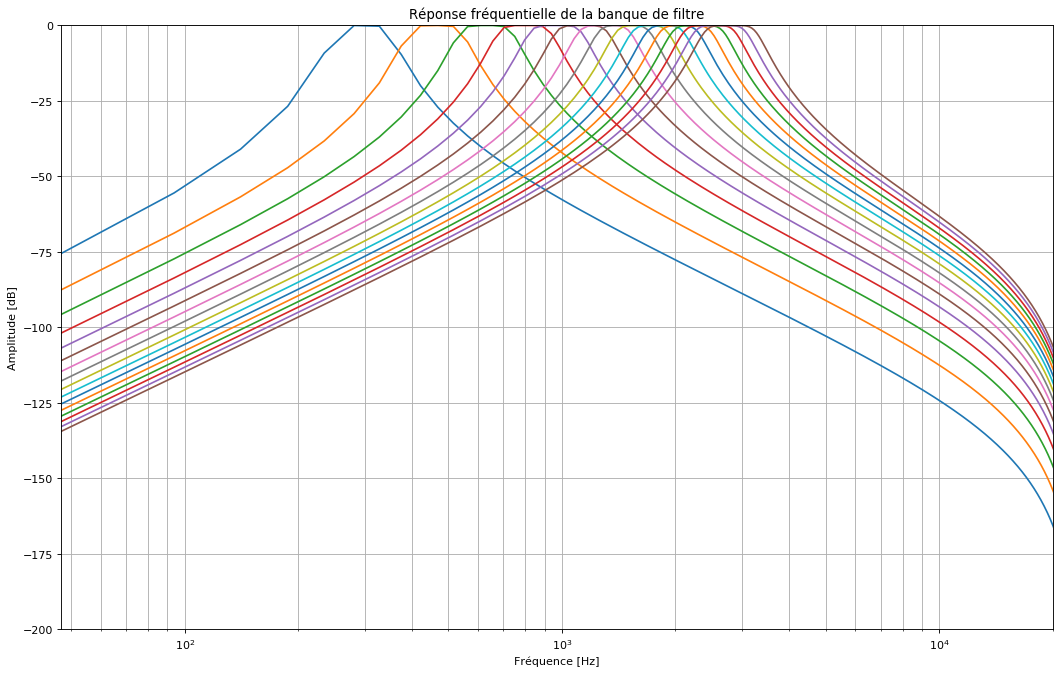

In [8]:
# Préparation de l'affichage
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

# Affichage des filtres
for i in range(len(filters)):
    # Calcul de la réponse fréquentielle du filtre
    b, a = filters[i]
    w, h = signal.freqz(b, a)
    # Affichage
    plt.semilogx((fs/(2*np.pi))*w, 20 * np.log10(abs(h)));

# Données d'affichage
plt.title("Réponse fréquentielle de la banque de filtre")
plt.xlabel('Fréquence [Hz]')
plt.ylabel('Amplitude [dB]')
plt.xlim(0, 20000)
plt.ylim(-200, 0)
plt.grid(which='both', axis='both')
plt.show()

#### Application de la banque de filtres

In [9]:
# Signaux filtrés
filtered = []
t = np.linspace(0, N/fs, N)
# Application de la banque de filtres
for i in range(len(filters)):
    # Calcul de la réponse
    b, a = filters[i]
    filtered.append(lfilter(b, a, y))

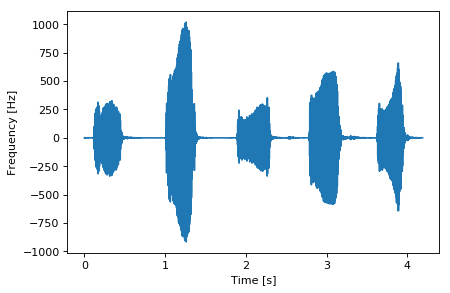

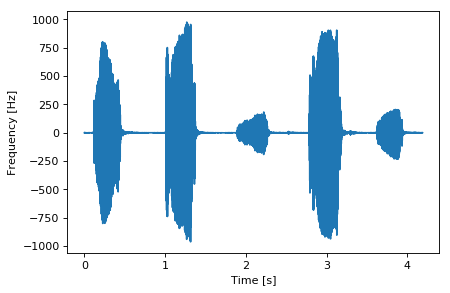

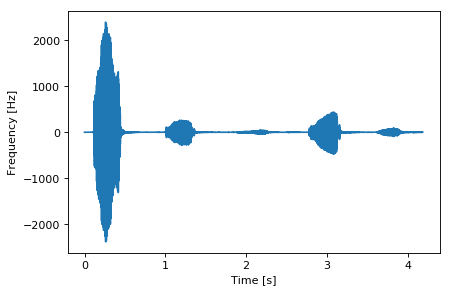

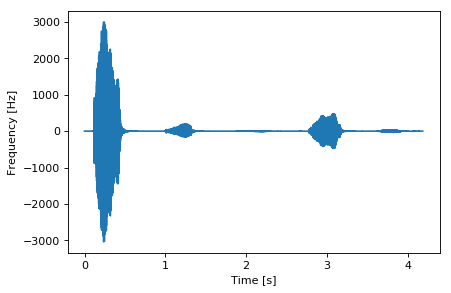

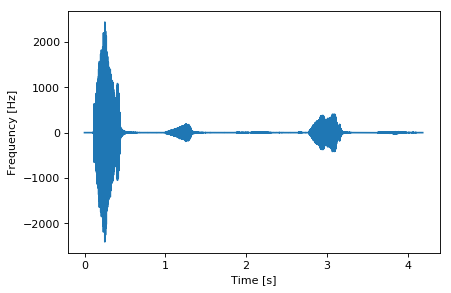

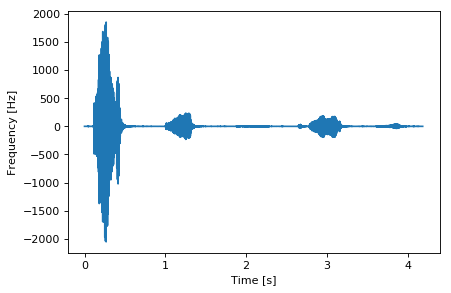

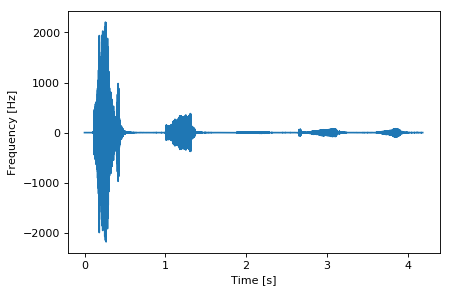

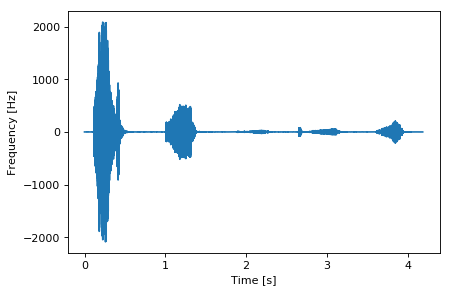

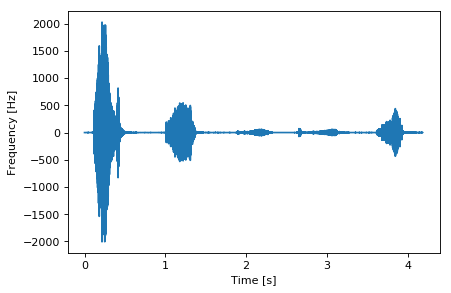

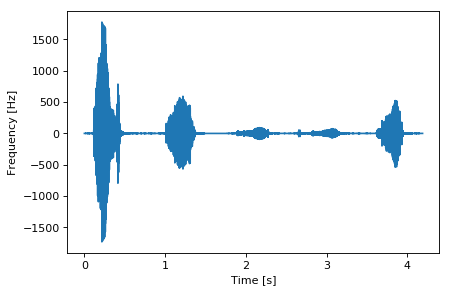

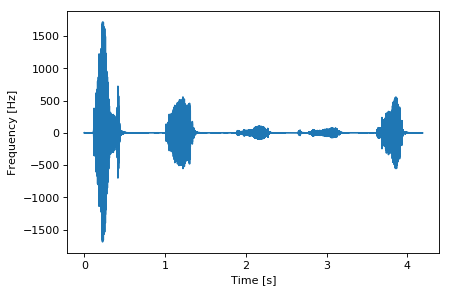

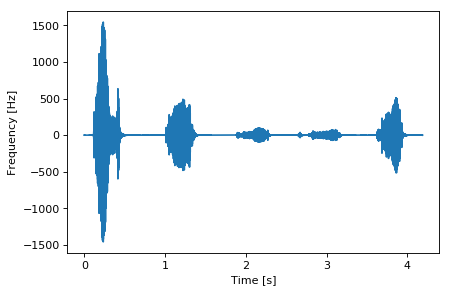

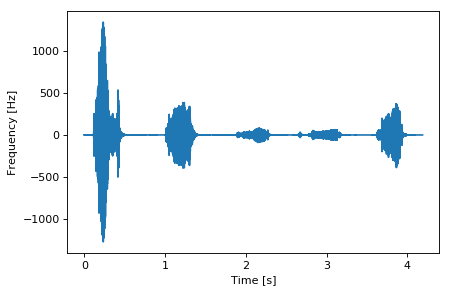

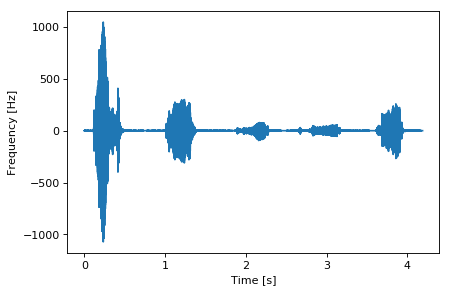

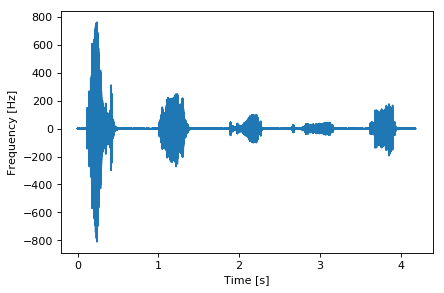

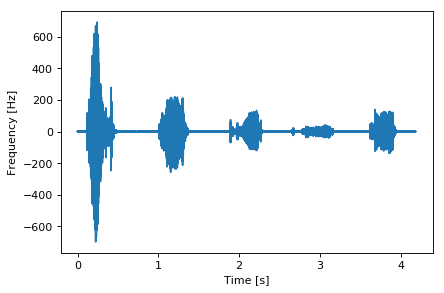

In [10]:
# Affichage des filtres
for i in range(len(filtered)):
    # Affichage du spectrogramme
    plt.figure(figsize=(6, 4), dpi= 80, facecolor='w', edgecolor='k')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.plot(t, filtered[i])
    plt.show()

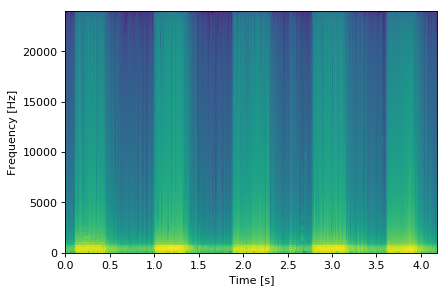

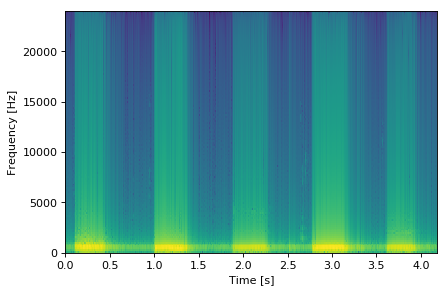

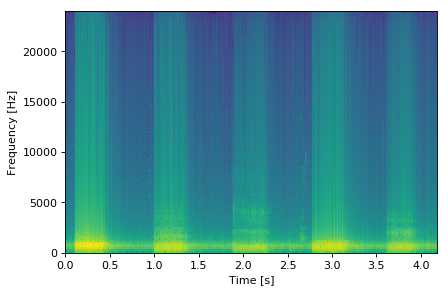

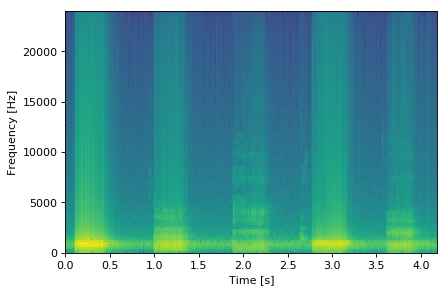

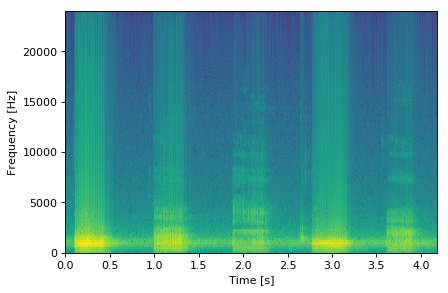

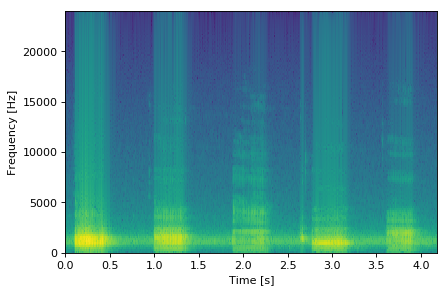

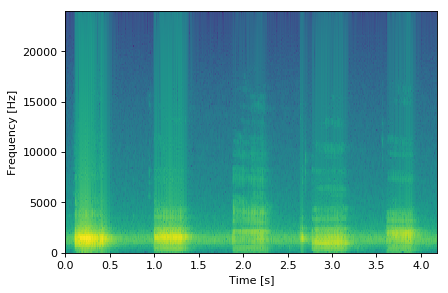

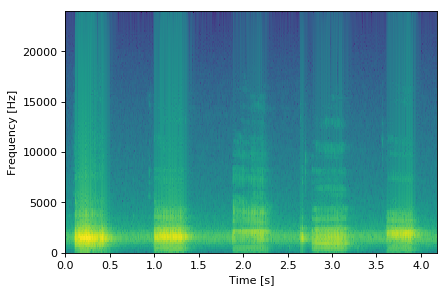

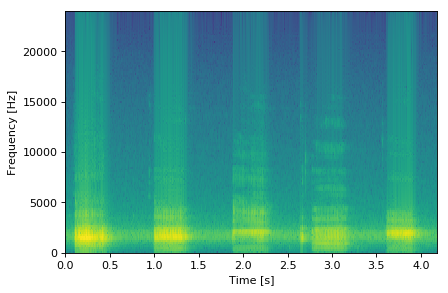

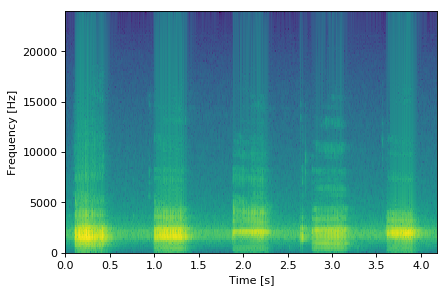

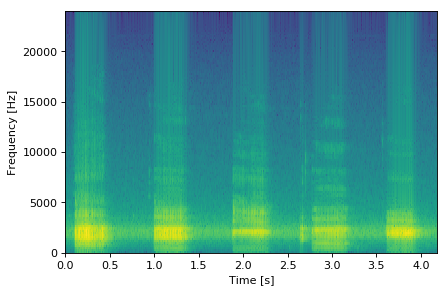

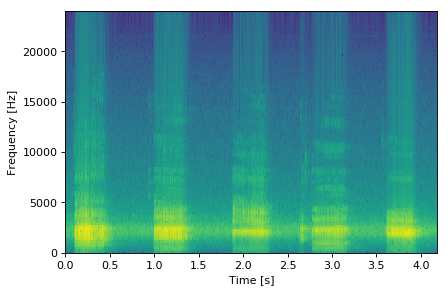

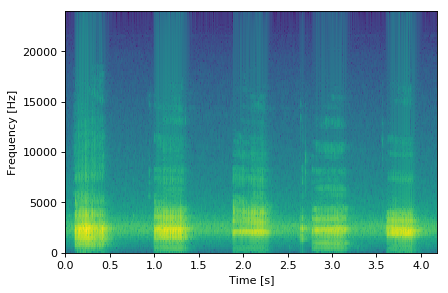

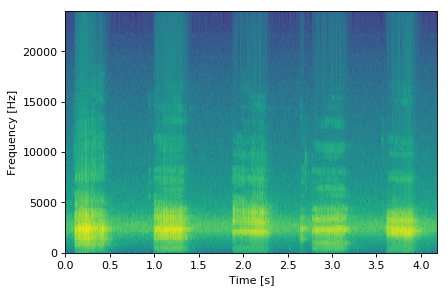

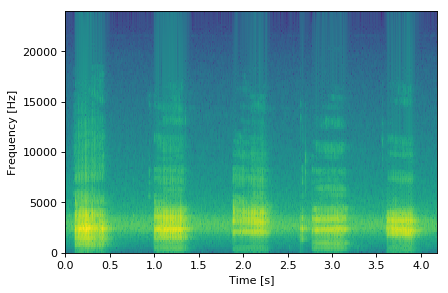

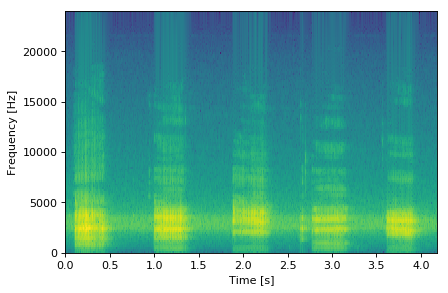

In [11]:
# Affichage des spectrogrammes
for i in range(len(filtered)):
    # Affichage du spectrogramme
    plt.figure(figsize=(6, 4), dpi= 80, facecolor='w', edgecolor='k')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.specgram(filtered[i], Fs=fs)
    plt.show()

    